<a href="https://colab.research.google.com/github/vxlot/paper_code/blob/main/ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion Probabilistic Model

Kernel Author: Minsu Kang

Email: mskang1478@gmail.com

requires Python=3.9 torch==1.12.1+cu113 jupyter==1.0.0 tqdm==4.64.0 matplotlib==3.5.3

paper https://arxiv.org/abs/2006.11239

非Unet实现

In [2]:
! pip install jupyter==1.0.0
! pip install tqdm==4.64.0
! pip install matplotlib==3.5.3
! pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

In [4]:
# Model Hyperparameters

dataset_path = './datasets'

cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")

dataset = 'MNIST'
img_size = (32, 32, 3)   if dataset == "CIFAR10" else (28, 28, 1) # (width, height, channels)

timestep_embedding_dim = 256
n_layers = 8
hidden_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

train_batch_size = 128
inference_batch_size = 64
lr = 5e-5
epochs = 200

seed = 1234

hidden_dims = [hidden_dim for _ in range(n_layers)]
torch.manual_seed(seed)
np.random.seed(seed)

## Step 1. Load (or download) Dataset

In [5]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

if dataset == 'CIFAR10':
    train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = CIFAR10(dataset_path, transform=transform, train=False, download=True)
else:
    train_dataset = MNIST(dataset_path, transform=transform, train=True, download=True)
    test_dataset  = MNIST(dataset_path, transform=transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=inference_batch_size, shuffle=False,  **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



## Step 2. Define our model: Denoising Diffusion Probabilistic Models (DDPMs)

Sinusoidal embedding for diffusion timestep

In [6]:
'''
   将位置信息编码成一个与输入数据一起传递给神经网络的张量，以帮助网络更好地理解输入的序列顺序
'''

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2  # 位置编码通常包括正弦（sin）和余弦（cos）两部分
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture.

In [7]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):

        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):

        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y

In [8]:
'''
   图像去噪
'''
class Denoiser(nn.Module):

    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        # 解包图像通道数
        _, _, img_C = image_resolution
        # 生成时间嵌入
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        # 卷积神经网络？
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))

        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))

        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)


    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x

        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))

        y = self.in_project(y)

        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)

        y = self.out_project(y)

        return y

model = Denoiser(image_resolution=img_size,
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=timestep_embedding_dim,
                 n_times=n_timesteps).to(DEVICE)

### Define Gaussian Diffusion

In [9]:
class Diffusion(nn.Module):
    def __init__(self, model, image_resolution=[32, 32, 3], n_times=1000, beta_minmax=[1e-4, 2e-2], device='cuda'):

        super(Diffusion, self).__init__()

        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution #解包图像分辨率

        self.model = model # 图像去噪的模型，通常是一个Denoiser模型

        # define linear variance schedule(betas)
        beta_1, beta_T = beta_minmax # 噪声方差（beta）的最小和最大值
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device) # 创建了一个线性的噪声方差（beta）调度表
        self.sqrt_betas = torch.sqrt(betas) # 平方根值通常在深度学习中更容易处理

        # define alpha for forward diffusion kernel
        self.alphas = 1 - betas # 1 - betas 计算了每个时间步骤的噪声方差的补数，即噪声的强度
        self.sqrt_alphas = torch.sqrt(self.alphas) # 平方根通常在深度学习中更容易处理，用于计算噪声
        alpha_bars = torch.cumprod(self.alphas, dim=0) # alphas的累积乘积
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1-alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        self.device = device

    def extract(self, a, t, x_shape):
        """
            从一个源张量 a 中根据索引张量 t 提取值，并对提取的值进行形状调整
            from lucidrains' implementation
                https://github.com/lucidrains/denoising-diffusion-pytorch/blob/beb2f2d8dd9b4f2bd5be4719f37082fe061ee450/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py#L376
        """
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))

    def scale_to_minus_one_to_one(self, x):
        # according to the DDPMs paper, normalization seems to be crucial to train reverse process network
        return x * 2 - 1

    def reverse_scale_to_zero_to_one(self, x):
        # 将数值范围从原来的 [0, 1] 映射到 [-1, 1]
        return (x + 1) * 0.5

    def make_noisy(self, x_zeros, t):
        ''' 根据给定的初始样本 x_zeros 和时间步骤 t，模拟前向扩散过程中的噪声效应，
            生成带有噪声的样本，并返回生成的样本以及随机噪声的张量'''
        # 生成一个与输入 x_zeros 相同形状的随机噪声张量 epsilon
        epsilon = torch.randn_like(x_zeros).to(self.device)
        # 从预先计算好的参数 sqrt_alpha_bars 和 sqrt_one_minus_alpha_bars 中提取值
        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)

        # 计算了带有噪声的样本 noisy_sample
        # sqrt(alpha_bar_t) * x_zero + sqrt(1-alpha_bar_t) * epsilon
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar

        return noisy_sample.detach(), epsilon


    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)

        B, _, _, _ = x_zeros.shape

        # (1) randomly choose diffusion time-step
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)

        # (2) forward diffusion process: perturb x_zeros with fixed variance schedule
        # 根据时间步骤 t 模拟前向扩散过程，生成带有噪声的样本 perturbed_images，并返回随机噪声 epsilon
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) predict epsilon(noise) given perturbed data at diffusion-timestep t.
        # 传入带有噪声的样本 perturbed_images 和时间步骤 t，用于预测噪声（epsilon）。
        # 模型会根据输入的样本和时间步骤，预测在当前时间步骤下的噪声情况。
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon


    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape
        if t > 1:
            # 将 z 初始化为与输入图像 x_t 相同形状的随机噪声
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # 预测当前时间步骤下的噪声（epsilon）
        epsilon_pred = self.model(x_t, timestep)
        # 提取一些系数
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # 从输入图像 x_t 中减去一个根据噪声
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*epsilon_pred) + sqrt_beta*z
        # 截断将其像素值限制在 [-1, 1] 的范围内，以确保输出的图像值合法
        return x_t_minus_1.clamp(-1., 1)

    def sample(self, N):
        '''生成一批具有一定时间步骤的图像样本，通过在每个时间步骤上逆向去噪的方式，从随机噪声逐步生成图像。'''
        # N 表示生成的样本数量
        # 创建了一个随机噪声张量 x_t 作为初始图像
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)

        # 反向去躁生成 from x_T to x_0
        for t in range(self.n_times-1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)
            x_t = self.denoise_at_t(x_t, timestep, t)

        # 归一化 x_0 into 0 ~ 1
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0


diffusion = Diffusion(model, image_resolution=img_size, n_times=n_timesteps,
                      beta_minmax=beta_minmax, device=DEVICE).to(DEVICE)

optimizer = Adam(diffusion.parameters(), lr=lr)
denoising_loss = nn.MSELoss()

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(diffusion))

Number of model parameters:  4870913


### Visualizing forward process

In [11]:
model.eval()
for batch_idx, (x, _) in enumerate(test_loader):
    x = x.to(DEVICE)
    # perturbed_images是经过扩散过程生成的受噪声影响的图像，epsilon是实际的噪声，pred_epsilon是模型预测的噪声
    perturbed_images, epsilon, pred_epsilon = diffusion(x)
    # 将经过扩散生成的图像perturbed_images从范围[-1, 1]逆向缩放到[0, 1]的范围
    perturbed_images = diffusion.reverse_scale_to_zero_to_one(perturbed_images)
    break

In [12]:
def show_image(x, idx):
    fig = plt.figure()
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

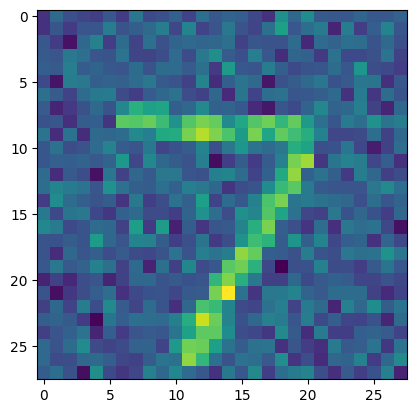

In [13]:
show_image(perturbed_images, idx=0)

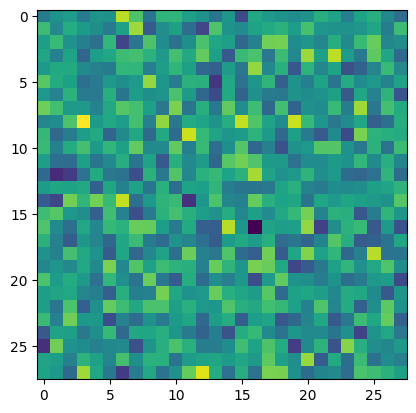

In [14]:
show_image(perturbed_images, idx=1)

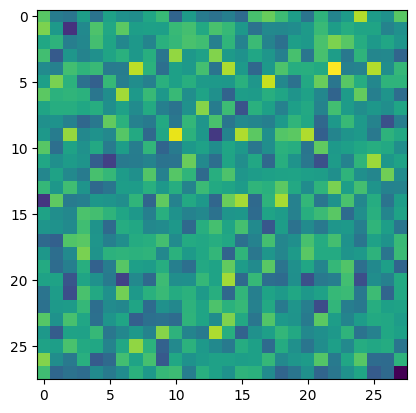

In [15]:
show_image(perturbed_images, idx=2)

## Step 3. Train Denoising Diffusion Probabilistic Models(DDPMs)

In [16]:
print("Start training DDPMs...")
model.train()

for epoch in range(epochs):
    noise_prediction_loss = 0
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()

        x = x.to(DEVICE)

        noisy_input, epsilon, pred_epsilon = diffusion(x)
        # 使用均方误差（MSE）来衡量模型的噪声预测与实际噪声之间的差异
        loss = denoising_loss(pred_epsilon, epsilon)

        noise_prediction_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_prediction_loss / batch_idx)

print("Finish!!")

Start training DDPMs...


100%|██████████| 469/469 [05:28<00:00,  1.43it/s]

	Epoch 1 complete! 	Denoising Loss:  0.09109685306524874



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 2 complete! 	Denoising Loss:  0.039196798351044074



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 3 complete! 	Denoising Loss:  0.03504510530326356



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 4 complete! 	Denoising Loss:  0.032994051221121326



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 5 complete! 	Denoising Loss:  0.03163271424018292



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 6 complete! 	Denoising Loss:  0.030458312354281418



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 7 complete! 	Denoising Loss:  0.02973120066568128



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 8 complete! 	Denoising Loss:  0.02902966112487464



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 9 complete! 	Denoising Loss:  0.02871340862276335



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 10 complete! 	Denoising Loss:  0.028198206212180547



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 11 complete! 	Denoising Loss:  0.027816405448202904



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 12 complete! 	Denoising Loss:  0.027279229380954534



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 13 complete! 	Denoising Loss:  0.027080309995187398



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 14 complete! 	Denoising Loss:  0.026839546739864044



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 15 complete! 	Denoising Loss:  0.026822550910819545



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 16 complete! 	Denoising Loss:  0.026659777252656273



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 17 complete! 	Denoising Loss:  0.026262851133465003



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 18 complete! 	Denoising Loss:  0.026130571057940394



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 19 complete! 	Denoising Loss:  0.026155919465435367



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 20 complete! 	Denoising Loss:  0.025685614488350276



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 21 complete! 	Denoising Loss:  0.0255650849495497



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 22 complete! 	Denoising Loss:  0.02557231977375017



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 23 complete! 	Denoising Loss:  0.02558977761043188



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 24 complete! 	Denoising Loss:  0.025286223994106308



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 25 complete! 	Denoising Loss:  0.025028673462314993



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 26 complete! 	Denoising Loss:  0.025205032414414436



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 27 complete! 	Denoising Loss:  0.025341526115647495



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 28 complete! 	Denoising Loss:  0.02482292393190611



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 29 complete! 	Denoising Loss:  0.02502299978549027



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 30 complete! 	Denoising Loss:  0.02487490469048548



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 31 complete! 	Denoising Loss:  0.024782167624236427



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 32 complete! 	Denoising Loss:  0.02465830394663872



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 33 complete! 	Denoising Loss:  0.02448720496514032



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 34 complete! 	Denoising Loss:  0.02458996831988677



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 35 complete! 	Denoising Loss:  0.02433313924070989



100%|██████████| 469/469 [05:31<00:00,  1.41it/s]

	Epoch 36 complete! 	Denoising Loss:  0.024132048985801447



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 37 complete! 	Denoising Loss:  0.024327849748377234



100%|██████████| 469/469 [05:32<00:00,  1.41it/s]

	Epoch 38 complete! 	Denoising Loss:  0.024300191388266463



 53%|█████▎    | 249/469 [02:56<02:36,  1.41it/s]


KeyboardInterrupt: ignored

## Step 4. Sample images from noise.

In [17]:
model.eval()

with torch.no_grad():
    generated_images = diffusion.sample(N=inference_batch_size)

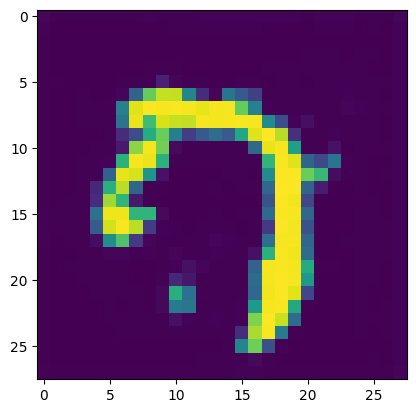

In [18]:
show_image(generated_images, idx=0)

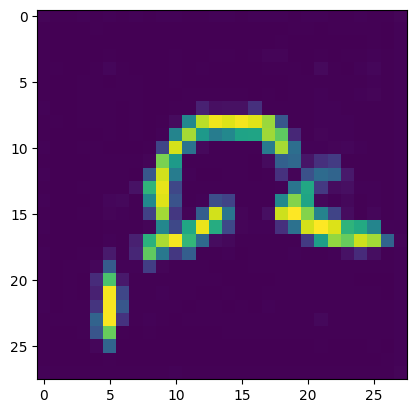

In [19]:
show_image(generated_images, idx=1)

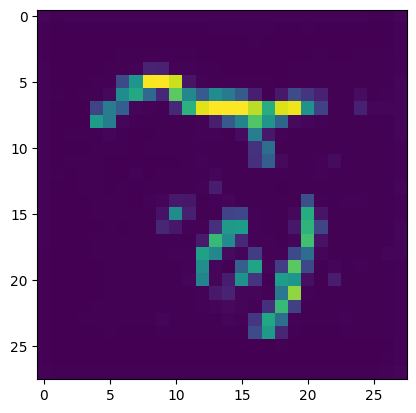

In [20]:
show_image(generated_images, idx=2)

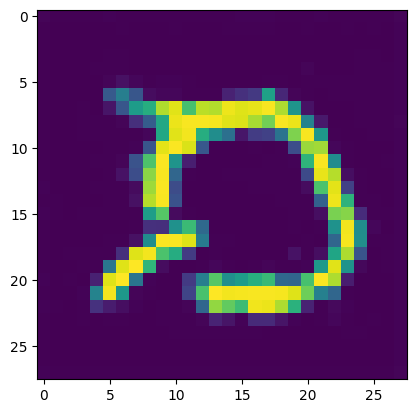

In [21]:
show_image(generated_images, idx=3)

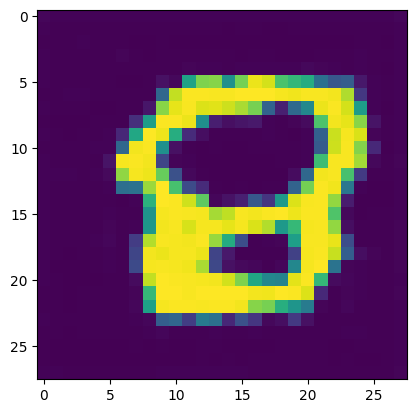

In [22]:
show_image(generated_images, idx=4)

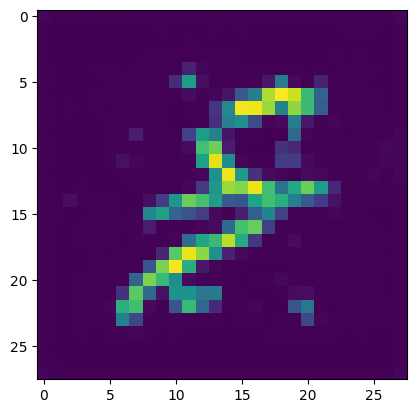

In [23]:
show_image(generated_images, idx=5)

### Comparison with ground-truth samples

In [ ]:
def draw_sample_image(x, postfix):

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

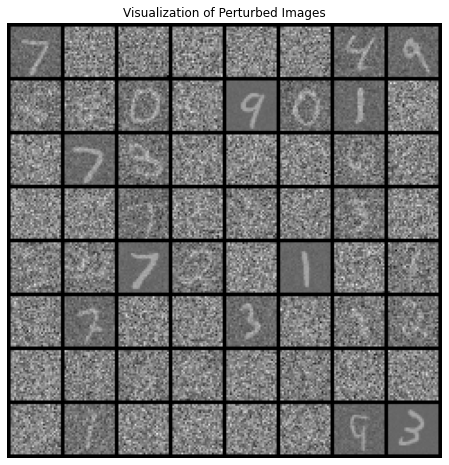

In [ ]:
draw_sample_image(perturbed_images, "Perturbed Images")

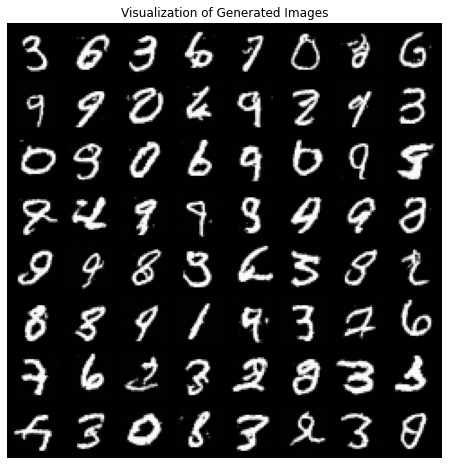

In [ ]:
draw_sample_image(generated_images, "Generated Images")

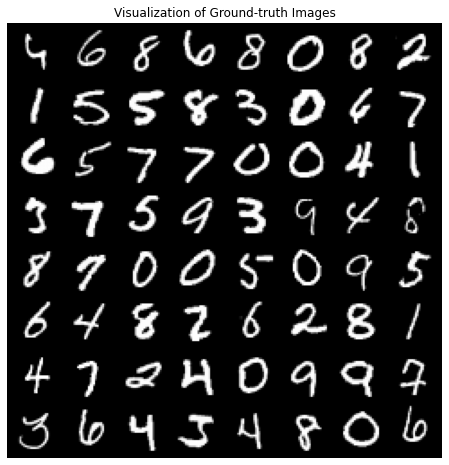

In [ ]:
draw_sample_image(x[:inference_batch_size], "Ground-truth Images")